# 学習済みモデルの特徴空間・プロトタイプを可視化

In [1]:
from pathlib import Path
import os, sys, json
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
# 例: 物理GPU1番だけを見せる
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

In [154]:
# === プロジェクトルートの指定 ===
# Notebook を CIDL-main の直下で開いているなら "." で OK
PROJECT_ROOT = Path("/home/kouyou/ContinualLearning/repexp/PyCIL").resolve()
os.chdir(PROJECT_ROOT)
sys.path.append(str(PROJECT_ROOT))

from trainer import _set_device  # 既存のヘルパをそのまま使う
from utils.data_manager import DataManager
from utils import factory

# === 使いたい設定ファイルと、どの phase を可視化するか ===
CONFIG_PATH = "exps/der_mu/baseline0/cifar100.json"   # 適宜変更
PHASE_ID    = 7                                         # ex) タスク3終了時のモデル → phase3.pkl

# === json 読み込み → args にする ===
with open(CONFIG_PATH) as f:
    args = json.load(f)

# device を training と同じ形式 (list of torch.device) に変換
_set_device(args)

print("model_name:", args["model_name"])
print("dataset   :", args["dataset"])
print("device    :", args["device"])

model_name: der-mu
dataset   : cifar100
device    : [device(type='cuda', index=0)]


## チェックポイントの設定

In [157]:
from glob import glob

def build_ckpt_dir(args, root=PROJECT_ROOT / "checkpoint"):
    
    """trainer / BaseLearner.save_checkpoint と同じ規則で checkpoint ディレクトリを作る"""
    init_cls = 0 if args ["init_cls"] == args["increment"] else args["init_cls"]
    log = "baseline" if "log" not in args else args["log"]
    
    ckpt_dir = "logs/{}/{}/{}/{}/{}/{}_{}_{}/".format(
        args["model_name"],
        log,
        args["dataset"],
        init_cls,
        args["increment"],
        args["prefix"], args["seed"][0], args["convnet_type"],
    )
    return ckpt_dir

ckpt_dir  = build_ckpt_dir(args)
ckpt_path = f"{ckpt_dir}/phase_{PHASE_ID}.pkl"

print("ckpt_dir :", ckpt_dir)
print("ckpt_path:", ckpt_path)

# # もし exists が False のときは、pattern で探す fallback も書いておくと楽
# if not ckpt_path.exists():
#     cand = glob(str(ckpt_dir / f"phase{PHASE_ID}*.pkl"))
#     print("fallback candidates:", cand)


ckpt_dir : logs/der-mu/baseline0/cifar100/0/10/reproduce_1993_resnet32/
ckpt_path: logs/der-mu/baseline0/cifar100/0/10/reproduce_1993_resnet32//phase_7.pkl


## データマネージャーとモデルの作成

In [158]:
# === DataManager & model を構築 ===
data_manager = DataManager(
    dataset_name=args["dataset"],
    shuffle=args["shuffle"],
    seed=args["seed"][0],
    init_cls=args["init_cls"],
    increment=args["increment"],
)

model = factory.get_model(args["model_name"], args)
model._network.to(args["device"][0])
model._device = args["device"][0]

# === checkpoint ロード ===
ckpt = torch.load(ckpt_path, map_location=model._device)
state_dict = ckpt["model_state_dict"]

# 1) checkpoint から fc の出力次元を読む
if "fc.weight" in state_dict:
    out_dim = state_dict["fc.weight"].shape[0]  # logits の次元数
    # 2) その次元数に合わせて fc を作成
    model._network.update_fc(out_dim)

# 3) その上で state_dict をロード
model._network.load_state_dict(state_dict)

# protos, forget_classes も保存されていれば復元
if "protos" in ckpt:
    model._protos = ckpt["protos"]
if "forget_classes" in ckpt and hasattr(model, "forget_classes"):
    model.forget_classes = ckpt["forget_classes"]

model.data_manager = data_manager

# model.forget_classes = [0, 1]

print("loaded tasks =", ckpt.get("tasks", "N/A"))
print("forget_classes:", getattr(model, "forget_classes", None))


Files already downloaded and verified
Files already downloaded and verified


<ipython-input-158-ff7035313b91>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=model._device)


RuntimeError: Error(s) in loading state_dict for DERNet:
	Unexpected key(s) in state_dict: "convnets.1.conv_1_3x3.weight", "convnets.1.bn_1.weight", "convnets.1.bn_1.bias", "convnets.1.bn_1.running_mean", "convnets.1.bn_1.running_var", "convnets.1.bn_1.num_batches_tracked", "convnets.1.stage_1.0.conv_a.weight", "convnets.1.stage_1.0.bn_a.weight", "convnets.1.stage_1.0.bn_a.bias", "convnets.1.stage_1.0.bn_a.running_mean", "convnets.1.stage_1.0.bn_a.running_var", "convnets.1.stage_1.0.bn_a.num_batches_tracked", "convnets.1.stage_1.0.conv_b.weight", "convnets.1.stage_1.0.bn_b.weight", "convnets.1.stage_1.0.bn_b.bias", "convnets.1.stage_1.0.bn_b.running_mean", "convnets.1.stage_1.0.bn_b.running_var", "convnets.1.stage_1.0.bn_b.num_batches_tracked", "convnets.1.stage_1.1.conv_a.weight", "convnets.1.stage_1.1.bn_a.weight", "convnets.1.stage_1.1.bn_a.bias", "convnets.1.stage_1.1.bn_a.running_mean", "convnets.1.stage_1.1.bn_a.running_var", "convnets.1.stage_1.1.bn_a.num_batches_tracked", "convnets.1.stage_1.1.conv_b.weight", "convnets.1.stage_1.1.bn_b.weight", "convnets.1.stage_1.1.bn_b.bias", "convnets.1.stage_1.1.bn_b.running_mean", "convnets.1.stage_1.1.bn_b.running_var", "convnets.1.stage_1.1.bn_b.num_batches_tracked", "convnets.1.stage_1.2.conv_a.weight", "convnets.1.stage_1.2.bn_a.weight", "convnets.1.stage_1.2.bn_a.bias", "convnets.1.stage_1.2.bn_a.running_mean", "convnets.1.stage_1.2.bn_a.running_var", "convnets.1.stage_1.2.bn_a.num_batches_tracked", "convnets.1.stage_1.2.conv_b.weight", "convnets.1.stage_1.2.bn_b.weight", "convnets.1.stage_1.2.bn_b.bias", "convnets.1.stage_1.2.bn_b.running_mean", "convnets.1.stage_1.2.bn_b.running_var", "convnets.1.stage_1.2.bn_b.num_batches_tracked", "convnets.1.stage_1.3.conv_a.weight", "convnets.1.stage_1.3.bn_a.weight", "convnets.1.stage_1.3.bn_a.bias", "convnets.1.stage_1.3.bn_a.running_mean", "convnets.1.stage_1.3.bn_a.running_var", "convnets.1.stage_1.3.bn_a.num_batches_tracked", "convnets.1.stage_1.3.conv_b.weight", "convnets.1.stage_1.3.bn_b.weight", "convnets.1.stage_1.3.bn_b.bias", "convnets.1.stage_1.3.bn_b.running_mean", "convnets.1.stage_1.3.bn_b.running_var", "convnets.1.stage_1.3.bn_b.num_batches_tracked", "convnets.1.stage_1.4.conv_a.weight", "convnets.1.stage_1.4.bn_a.weight", "convnets.1.stage_1.4.bn_a.bias", "convnets.1.stage_1.4.bn_a.running_mean", "convnets.1.stage_1.4.bn_a.running_var", "convnets.1.stage_1.4.bn_a.num_batches_tracked", "convnets.1.stage_1.4.conv_b.weight", "convnets.1.stage_1.4.bn_b.weight", "convnets.1.stage_1.4.bn_b.bias", "convnets.1.stage_1.4.bn_b.running_mean", "convnets.1.stage_1.4.bn_b.running_var", "convnets.1.stage_1.4.bn_b.num_batches_tracked", "convnets.1.stage_2.0.conv_a.weight", "convnets.1.stage_2.0.bn_a.weight", "convnets.1.stage_2.0.bn_a.bias", "convnets.1.stage_2.0.bn_a.running_mean", "convnets.1.stage_2.0.bn_a.running_var", "convnets.1.stage_2.0.bn_a.num_batches_tracked", "convnets.1.stage_2.0.conv_b.weight", "convnets.1.stage_2.0.bn_b.weight", "convnets.1.stage_2.0.bn_b.bias", "convnets.1.stage_2.0.bn_b.running_mean", "convnets.1.stage_2.0.bn_b.running_var", "convnets.1.stage_2.0.bn_b.num_batches_tracked", "convnets.1.stage_2.1.conv_a.weight", "convnets.1.stage_2.1.bn_a.weight", "convnets.1.stage_2.1.bn_a.bias", "convnets.1.stage_2.1.bn_a.running_mean", "convnets.1.stage_2.1.bn_a.running_var", "convnets.1.stage_2.1.bn_a.num_batches_tracked", "convnets.1.stage_2.1.conv_b.weight", "convnets.1.stage_2.1.bn_b.weight", "convnets.1.stage_2.1.bn_b.bias", "convnets.1.stage_2.1.bn_b.running_mean", "convnets.1.stage_2.1.bn_b.running_var", "convnets.1.stage_2.1.bn_b.num_batches_tracked", "convnets.1.stage_2.2.conv_a.weight", "convnets.1.stage_2.2.bn_a.weight", "convnets.1.stage_2.2.bn_a.bias", "convnets.1.stage_2.2.bn_a.running_mean", "convnets.1.stage_2.2.bn_a.running_var", "convnets.1.stage_2.2.bn_a.num_batches_tracked", "convnets.1.stage_2.2.conv_b.weight", "convnets.1.stage_2.2.bn_b.weight", "convnets.1.stage_2.2.bn_b.bias", "convnets.1.stage_2.2.bn_b.running_mean", "convnets.1.stage_2.2.bn_b.running_var", "convnets.1.stage_2.2.bn_b.num_batches_tracked", "convnets.1.stage_2.3.conv_a.weight", "convnets.1.stage_2.3.bn_a.weight", "convnets.1.stage_2.3.bn_a.bias", "convnets.1.stage_2.3.bn_a.running_mean", "convnets.1.stage_2.3.bn_a.running_var", "convnets.1.stage_2.3.bn_a.num_batches_tracked", "convnets.1.stage_2.3.conv_b.weight", "convnets.1.stage_2.3.bn_b.weight", "convnets.1.stage_2.3.bn_b.bias", "convnets.1.stage_2.3.bn_b.running_mean", "convnets.1.stage_2.3.bn_b.running_var", "convnets.1.stage_2.3.bn_b.num_batches_tracked", "convnets.1.stage_2.4.conv_a.weight", "convnets.1.stage_2.4.bn_a.weight", "convnets.1.stage_2.4.bn_a.bias", "convnets.1.stage_2.4.bn_a.running_mean", "convnets.1.stage_2.4.bn_a.running_var", "convnets.1.stage_2.4.bn_a.num_batches_tracked", "convnets.1.stage_2.4.conv_b.weight", "convnets.1.stage_2.4.bn_b.weight", "convnets.1.stage_2.4.bn_b.bias", "convnets.1.stage_2.4.bn_b.running_mean", "convnets.1.stage_2.4.bn_b.running_var", "convnets.1.stage_2.4.bn_b.num_batches_tracked", "convnets.1.stage_3.0.conv_a.weight", "convnets.1.stage_3.0.bn_a.weight", "convnets.1.stage_3.0.bn_a.bias", "convnets.1.stage_3.0.bn_a.running_mean", "convnets.1.stage_3.0.bn_a.running_var", "convnets.1.stage_3.0.bn_a.num_batches_tracked", "convnets.1.stage_3.0.conv_b.weight", "convnets.1.stage_3.0.bn_b.weight", "convnets.1.stage_3.0.bn_b.bias", "convnets.1.stage_3.0.bn_b.running_mean", "convnets.1.stage_3.0.bn_b.running_var", "convnets.1.stage_3.0.bn_b.num_batches_tracked", "convnets.1.stage_3.1.conv_a.weight", "convnets.1.stage_3.1.bn_a.weight", "convnets.1.stage_3.1.bn_a.bias", "convnets.1.stage_3.1.bn_a.running_mean", "convnets.1.stage_3.1.bn_a.running_var", "convnets.1.stage_3.1.bn_a.num_batches_tracked", "convnets.1.stage_3.1.conv_b.weight", "convnets.1.stage_3.1.bn_b.weight", "convnets.1.stage_3.1.bn_b.bias", "convnets.1.stage_3.1.bn_b.running_mean", "convnets.1.stage_3.1.bn_b.running_var", "convnets.1.stage_3.1.bn_b.num_batches_tracked", "convnets.1.stage_3.2.conv_a.weight", "convnets.1.stage_3.2.bn_a.weight", "convnets.1.stage_3.2.bn_a.bias", "convnets.1.stage_3.2.bn_a.running_mean", "convnets.1.stage_3.2.bn_a.running_var", "convnets.1.stage_3.2.bn_a.num_batches_tracked", "convnets.1.stage_3.2.conv_b.weight", "convnets.1.stage_3.2.bn_b.weight", "convnets.1.stage_3.2.bn_b.bias", "convnets.1.stage_3.2.bn_b.running_mean", "convnets.1.stage_3.2.bn_b.running_var", "convnets.1.stage_3.2.bn_b.num_batches_tracked", "convnets.1.stage_3.3.conv_a.weight", "convnets.1.stage_3.3.bn_a.weight", "convnets.1.stage_3.3.bn_a.bias", "convnets.1.stage_3.3.bn_a.running_mean", "convnets.1.stage_3.3.bn_a.running_var", "convnets.1.stage_3.3.bn_a.num_batches_tracked", "convnets.1.stage_3.3.conv_b.weight", "convnets.1.stage_3.3.bn_b.weight", "convnets.1.stage_3.3.bn_b.bias", "convnets.1.stage_3.3.bn_b.running_mean", "convnets.1.stage_3.3.bn_b.running_var", "convnets.1.stage_3.3.bn_b.num_batches_tracked", "convnets.1.stage_3.4.conv_a.weight", "convnets.1.stage_3.4.bn_a.weight", "convnets.1.stage_3.4.bn_a.bias", "convnets.1.stage_3.4.bn_a.running_mean", "convnets.1.stage_3.4.bn_a.running_var", "convnets.1.stage_3.4.bn_a.num_batches_tracked", "convnets.1.stage_3.4.conv_b.weight", "convnets.1.stage_3.4.bn_b.weight", "convnets.1.stage_3.4.bn_b.bias", "convnets.1.stage_3.4.bn_b.running_mean", "convnets.1.stage_3.4.bn_b.running_var", "convnets.1.stage_3.4.bn_b.num_batches_tracked", "convnets.1.fc.weight", "convnets.1.fc.bias", "convnets.2.conv_1_3x3.weight", "convnets.2.bn_1.weight", "convnets.2.bn_1.bias", "convnets.2.bn_1.running_mean", "convnets.2.bn_1.running_var", "convnets.2.bn_1.num_batches_tracked", "convnets.2.stage_1.0.conv_a.weight", "convnets.2.stage_1.0.bn_a.weight", "convnets.2.stage_1.0.bn_a.bias", "convnets.2.stage_1.0.bn_a.running_mean", "convnets.2.stage_1.0.bn_a.running_var", "convnets.2.stage_1.0.bn_a.num_batches_tracked", "convnets.2.stage_1.0.conv_b.weight", "convnets.2.stage_1.0.bn_b.weight", "convnets.2.stage_1.0.bn_b.bias", "convnets.2.stage_1.0.bn_b.running_mean", "convnets.2.stage_1.0.bn_b.running_var", "convnets.2.stage_1.0.bn_b.num_batches_tracked", "convnets.2.stage_1.1.conv_a.weight", "convnets.2.stage_1.1.bn_a.weight", "convnets.2.stage_1.1.bn_a.bias", "convnets.2.stage_1.1.bn_a.running_mean", "convnets.2.stage_1.1.bn_a.running_var", "convnets.2.stage_1.1.bn_a.num_batches_tracked", "convnets.2.stage_1.1.conv_b.weight", "convnets.2.stage_1.1.bn_b.weight", "convnets.2.stage_1.1.bn_b.bias", "convnets.2.stage_1.1.bn_b.running_mean", "convnets.2.stage_1.1.bn_b.running_var", "convnets.2.stage_1.1.bn_b.num_batches_tracked", "convnets.2.stage_1.2.conv_a.weight", "convnets.2.stage_1.2.bn_a.weight", "convnets.2.stage_1.2.bn_a.bias", "convnets.2.stage_1.2.bn_a.running_mean", "convnets.2.stage_1.2.bn_a.running_var", "convnets.2.stage_1.2.bn_a.num_batches_tracked", "convnets.2.stage_1.2.conv_b.weight", "convnets.2.stage_1.2.bn_b.weight", "convnets.2.stage_1.2.bn_b.bias", "convnets.2.stage_1.2.bn_b.running_mean", "convnets.2.stage_1.2.bn_b.running_var", "convnets.2.stage_1.2.bn_b.num_batches_tracked", "convnets.2.stage_1.3.conv_a.weight", "convnets.2.stage_1.3.bn_a.weight", "convnets.2.stage_1.3.bn_a.bias", "convnets.2.stage_1.3.bn_a.running_mean", "convnets.2.stage_1.3.bn_a.running_var", "convnets.2.stage_1.3.bn_a.num_batches_tracked", "convnets.2.stage_1.3.conv_b.weight", "convnets.2.stage_1.3.bn_b.weight", "convnets.2.stage_1.3.bn_b.bias", "convnets.2.stage_1.3.bn_b.running_mean", "convnets.2.stage_1.3.bn_b.running_var", "convnets.2.stage_1.3.bn_b.num_batches_tracked", "convnets.2.stage_1.4.conv_a.weight", "convnets.2.stage_1.4.bn_a.weight", "convnets.2.stage_1.4.bn_a.bias", "convnets.2.stage_1.4.bn_a.running_mean", "convnets.2.stage_1.4.bn_a.running_var", "convnets.2.stage_1.4.bn_a.num_batches_tracked", "convnets.2.stage_1.4.conv_b.weight", "convnets.2.stage_1.4.bn_b.weight", "convnets.2.stage_1.4.bn_b.bias", "convnets.2.stage_1.4.bn_b.running_mean", "convnets.2.stage_1.4.bn_b.running_var", "convnets.2.stage_1.4.bn_b.num_batches_tracked", "convnets.2.stage_2.0.conv_a.weight", "convnets.2.stage_2.0.bn_a.weight", "convnets.2.stage_2.0.bn_a.bias", "convnets.2.stage_2.0.bn_a.running_mean", "convnets.2.stage_2.0.bn_a.running_var", "convnets.2.stage_2.0.bn_a.num_batches_tracked", "convnets.2.stage_2.0.conv_b.weight", "convnets.2.stage_2.0.bn_b.weight", "convnets.2.stage_2.0.bn_b.bias", "convnets.2.stage_2.0.bn_b.running_mean", "convnets.2.stage_2.0.bn_b.running_var", "convnets.2.stage_2.0.bn_b.num_batches_tracked", "convnets.2.stage_2.1.conv_a.weight", "convnets.2.stage_2.1.bn_a.weight", "convnets.2.stage_2.1.bn_a.bias", "convnets.2.stage_2.1.bn_a.running_mean", "convnets.2.stage_2.1.bn_a.running_var", "convnets.2.stage_2.1.bn_a.num_batches_tracked", "convnets.2.stage_2.1.conv_b.weight", "convnets.2.stage_2.1.bn_b.weight", "convnets.2.stage_2.1.bn_b.bias", "convnets.2.stage_2.1.bn_b.running_mean", "convnets.2.stage_2.1.bn_b.running_var", "convnets.2.stage_2.1.bn_b.num_batches_tracked", "convnets.2.stage_2.2.conv_a.weight", "convnets.2.stage_2.2.bn_a.weight", "convnets.2.stage_2.2.bn_a.bias", "convnets.2.stage_2.2.bn_a.running_mean", "convnets.2.stage_2.2.bn_a.running_var", "convnets.2.stage_2.2.bn_a.num_batches_tracked", "convnets.2.stage_2.2.conv_b.weight", "convnets.2.stage_2.2.bn_b.weight", "convnets.2.stage_2.2.bn_b.bias", "convnets.2.stage_2.2.bn_b.running_mean", "convnets.2.stage_2.2.bn_b.running_var", "convnets.2.stage_2.2.bn_b.num_batches_tracked", "convnets.2.stage_2.3.conv_a.weight", "convnets.2.stage_2.3.bn_a.weight", "convnets.2.stage_2.3.bn_a.bias", "convnets.2.stage_2.3.bn_a.running_mean", "convnets.2.stage_2.3.bn_a.running_var", "convnets.2.stage_2.3.bn_a.num_batches_tracked", "convnets.2.stage_2.3.conv_b.weight", "convnets.2.stage_2.3.bn_b.weight", "convnets.2.stage_2.3.bn_b.bias", "convnets.2.stage_2.3.bn_b.running_mean", "convnets.2.stage_2.3.bn_b.running_var", "convnets.2.stage_2.3.bn_b.num_batches_tracked", "convnets.2.stage_2.4.conv_a.weight", "convnets.2.stage_2.4.bn_a.weight", "convnets.2.stage_2.4.bn_a.bias", "convnets.2.stage_2.4.bn_a.running_mean", "convnets.2.stage_2.4.bn_a.running_var", "convnets.2.stage_2.4.bn_a.num_batches_tracked", "convnets.2.stage_2.4.conv_b.weight", "convnets.2.stage_2.4.bn_b.weight", "convnets.2.stage_2.4.bn_b.bias", "convnets.2.stage_2.4.bn_b.running_mean", "convnets.2.stage_2.4.bn_b.running_var", "convnets.2.stage_2.4.bn_b.num_batches_tracked", "convnets.2.stage_3.0.conv_a.weight", "convnets.2.stage_3.0.bn_a.weight", "convnets.2.stage_3.0.bn_a.bias", "convnets.2.stage_3.0.bn_a.running_mean", "convnets.2.stage_3.0.bn_a.running_var", "convnets.2.stage_3.0.bn_a.num_batches_tracked", "convnets.2.stage_3.0.conv_b.weight", "convnets.2.stage_3.0.bn_b.weight", "convnets.2.stage_3.0.bn_b.bias", "convnets.2.stage_3.0.bn_b.running_mean", "convnets.2.stage_3.0.bn_b.running_var", "convnets.2.stage_3.0.bn_b.num_batches_tracked", "convnets.2.stage_3.1.conv_a.weight", "convnets.2.stage_3.1.bn_a.weight", "convnets.2.stage_3.1.bn_a.bias", "convnets.2.stage_3.1.bn_a.running_mean", "convnets.2.stage_3.1.bn_a.running_var", "convnets.2.stage_3.1.bn_a.num_batches_tracked", "convnets.2.stage_3.1.conv_b.weight", "convnets.2.stage_3.1.bn_b.weight", "convnets.2.stage_3.1.bn_b.bias", "convnets.2.stage_3.1.bn_b.running_mean", "convnets.2.stage_3.1.bn_b.running_var", "convnets.2.stage_3.1.bn_b.num_batches_tracked", "convnets.2.stage_3.2.conv_a.weight", "convnets.2.stage_3.2.bn_a.weight", "convnets.2.stage_3.2.bn_a.bias", "convnets.2.stage_3.2.bn_a.running_mean", "convnets.2.stage_3.2.bn_a.running_var", "convnets.2.stage_3.2.bn_a.num_batches_tracked", "convnets.2.stage_3.2.conv_b.weight", "convnets.2.stage_3.2.bn_b.weight", "convnets.2.stage_3.2.bn_b.bias", "convnets.2.stage_3.2.bn_b.running_mean", "convnets.2.stage_3.2.bn_b.running_var", "convnets.2.stage_3.2.bn_b.num_batches_tracked", "convnets.2.stage_3.3.conv_a.weight", "convnets.2.stage_3.3.bn_a.weight", "convnets.2.stage_3.3.bn_a.bias", "convnets.2.stage_3.3.bn_a.running_mean", "convnets.2.stage_3.3.bn_a.running_var", "convnets.2.stage_3.3.bn_a.num_batches_tracked", "convnets.2.stage_3.3.conv_b.weight", "convnets.2.stage_3.3.bn_b.weight", "convnets.2.stage_3.3.bn_b.bias", "convnets.2.stage_3.3.bn_b.running_mean", "convnets.2.stage_3.3.bn_b.running_var", "convnets.2.stage_3.3.bn_b.num_batches_tracked", "convnets.2.stage_3.4.conv_a.weight", "convnets.2.stage_3.4.bn_a.weight", "convnets.2.stage_3.4.bn_a.bias", "convnets.2.stage_3.4.bn_a.running_mean", "convnets.2.stage_3.4.bn_a.running_var", "convnets.2.stage_3.4.bn_a.num_batches_tracked", "convnets.2.stage_3.4.conv_b.weight", "convnets.2.stage_3.4.bn_b.weight", "convnets.2.stage_3.4.bn_b.bias", "convnets.2.stage_3.4.bn_b.running_mean", "convnets.2.stage_3.4.bn_b.running_var", "convnets.2.stage_3.4.bn_b.num_batches_tracked", "convnets.2.fc.weight", "convnets.2.fc.bias", "convnets.3.conv_1_3x3.weight", "convnets.3.bn_1.weight", "convnets.3.bn_1.bias", "convnets.3.bn_1.running_mean", "convnets.3.bn_1.running_var", "convnets.3.bn_1.num_batches_tracked", "convnets.3.stage_1.0.conv_a.weight", "convnets.3.stage_1.0.bn_a.weight", "convnets.3.stage_1.0.bn_a.bias", "convnets.3.stage_1.0.bn_a.running_mean", "convnets.3.stage_1.0.bn_a.running_var", "convnets.3.stage_1.0.bn_a.num_batches_tracked", "convnets.3.stage_1.0.conv_b.weight", "convnets.3.stage_1.0.bn_b.weight", "convnets.3.stage_1.0.bn_b.bias", "convnets.3.stage_1.0.bn_b.running_mean", "convnets.3.stage_1.0.bn_b.running_var", "convnets.3.stage_1.0.bn_b.num_batches_tracked", "convnets.3.stage_1.1.conv_a.weight", "convnets.3.stage_1.1.bn_a.weight", "convnets.3.stage_1.1.bn_a.bias", "convnets.3.stage_1.1.bn_a.running_mean", "convnets.3.stage_1.1.bn_a.running_var", "convnets.3.stage_1.1.bn_a.num_batches_tracked", "convnets.3.stage_1.1.conv_b.weight", "convnets.3.stage_1.1.bn_b.weight", "convnets.3.stage_1.1.bn_b.bias", "convnets.3.stage_1.1.bn_b.running_mean", "convnets.3.stage_1.1.bn_b.running_var", "convnets.3.stage_1.1.bn_b.num_batches_tracked", "convnets.3.stage_1.2.conv_a.weight", "convnets.3.stage_1.2.bn_a.weight", "convnets.3.stage_1.2.bn_a.bias", "convnets.3.stage_1.2.bn_a.running_mean", "convnets.3.stage_1.2.bn_a.running_var", "convnets.3.stage_1.2.bn_a.num_batches_tracked", "convnets.3.stage_1.2.conv_b.weight", "convnets.3.stage_1.2.bn_b.weight", "convnets.3.stage_1.2.bn_b.bias", "convnets.3.stage_1.2.bn_b.running_mean", "convnets.3.stage_1.2.bn_b.running_var", "convnets.3.stage_1.2.bn_b.num_batches_tracked", "convnets.3.stage_1.3.conv_a.weight", "convnets.3.stage_1.3.bn_a.weight", "convnets.3.stage_1.3.bn_a.bias", "convnets.3.stage_1.3.bn_a.running_mean", "convnets.3.stage_1.3.bn_a.running_var", "convnets.3.stage_1.3.bn_a.num_batches_tracked", "convnets.3.stage_1.3.conv_b.weight", "convnets.3.stage_1.3.bn_b.weight", "convnets.3.stage_1.3.bn_b.bias", "convnets.3.stage_1.3.bn_b.running_mean", "convnets.3.stage_1.3.bn_b.running_var", "convnets.3.stage_1.3.bn_b.num_batches_tracked", "convnets.3.stage_1.4.conv_a.weight", "convnets.3.stage_1.4.bn_a.weight", "convnets.3.stage_1.4.bn_a.bias", "convnets.3.stage_1.4.bn_a.running_mean", "convnets.3.stage_1.4.bn_a.running_var", "convnets.3.stage_1.4.bn_a.num_batches_tracked", "convnets.3.stage_1.4.conv_b.weight", "convnets.3.stage_1.4.bn_b.weight", "convnets.3.stage_1.4.bn_b.bias", "convnets.3.stage_1.4.bn_b.running_mean", "convnets.3.stage_1.4.bn_b.running_var", "convnets.3.stage_1.4.bn_b.num_batches_tracked", "convnets.3.stage_2.0.conv_a.weight", "convnets.3.stage_2.0.bn_a.weight", "convnets.3.stage_2.0.bn_a.bias", "convnets.3.stage_2.0.bn_a.running_mean", "convnets.3.stage_2.0.bn_a.running_var", "convnets.3.stage_2.0.bn_a.num_batches_tracked", "convnets.3.stage_2.0.conv_b.weight", "convnets.3.stage_2.0.bn_b.weight", "convnets.3.stage_2.0.bn_b.bias", "convnets.3.stage_2.0.bn_b.running_mean", "convnets.3.stage_2.0.bn_b.running_var", "convnets.3.stage_2.0.bn_b.num_batches_tracked", "convnets.3.stage_2.1.conv_a.weight", "convnets.3.stage_2.1.bn_a.weight", "convnets.3.stage_2.1.bn_a.bias", "convnets.3.stage_2.1.bn_a.running_mean", "convnets.3.stage_2.1.bn_a.running_var", "convnets.3.stage_2.1.bn_a.num_batches_tracked", "convnets.3.stage_2.1.conv_b.weight", "convnets.3.stage_2.1.bn_b.weight", "convnets.3.stage_2.1.bn_b.bias", "convnets.3.stage_2.1.bn_b.running_mean", "convnets.3.stage_2.1.bn_b.running_var", "convnets.3.stage_2.1.bn_b.num_batches_tracked", "convnets.3.stage_2.2.conv_a.weight", "convnets.3.stage_2.2.bn_a.weight", "convnets.3.stage_2.2.bn_a.bias", "convnets.3.stage_2.2.bn_a.running_mean", "convnets.3.stage_2.2.bn_a.running_var", "convnets.3.stage_2.2.bn_a.num_batches_tracked", "convnets.3.stage_2.2.conv_b.weight", "convnets.3.stage_2.2.bn_b.weight", "convnets.3.stage_2.2.bn_b.bias", "convnets.3.stage_2.2.bn_b.running_mean", "convnets.3.stage_2.2.bn_b.running_var", "convnets.3.stage_2.2.bn_b.num_batches_tracked", "convnets.3.stage_2.3.conv_a.weight", "convnets.3.stage_2.3.bn_a.weight", "convnets.3.stage_2.3.bn_a.bias", "convnets.3.stage_2.3.bn_a.running_mean", "convnets.3.stage_2.3.bn_a.running_var", "convnets.3.stage_2.3.bn_a.num_batches_tracked", "convnets.3.stage_2.3.conv_b.weight", "convnets.3.stage_2.3.bn_b.weight", "convnets.3.stage_2.3.bn_b.bias", "convnets.3.stage_2.3.bn_b.running_mean", "convnets.3.stage_2.3.bn_b.running_var", "convnets.3.stage_2.3.bn_b.num_batches_tracked", "convnets.3.stage_2.4.conv_a.weight", "convnets.3.stage_2.4.bn_a.weight", "convnets.3.stage_2.4.bn_a.bias", "convnets.3.stage_2.4.bn_a.running_mean", "convnets.3.stage_2.4.bn_a.running_var", "convnets.3.stage_2.4.bn_a.num_batches_tracked", "convnets.3.stage_2.4.conv_b.weight", "convnets.3.stage_2.4.bn_b.weight", "convnets.3.stage_2.4.bn_b.bias", "convnets.3.stage_2.4.bn_b.running_mean", "convnets.3.stage_2.4.bn_b.running_var", "convnets.3.stage_2.4.bn_b.num_batches_tracked", "convnets.3.stage_3.0.conv_a.weight", "convnets.3.stage_3.0.bn_a.weight", "convnets.3.stage_3.0.bn_a.bias", "convnets.3.stage_3.0.bn_a.running_mean", "convnets.3.stage_3.0.bn_a.running_var", "convnets.3.stage_3.0.bn_a.num_batches_tracked", "convnets.3.stage_3.0.conv_b.weight", "convnets.3.stage_3.0.bn_b.weight", "convnets.3.stage_3.0.bn_b.bias", "convnets.3.stage_3.0.bn_b.running_mean", "convnets.3.stage_3.0.bn_b.running_var", "convnets.3.stage_3.0.bn_b.num_batches_tracked", "convnets.3.stage_3.1.conv_a.weight", "convnets.3.stage_3.1.bn_a.weight", "convnets.3.stage_3.1.bn_a.bias", "convnets.3.stage_3.1.bn_a.running_mean", "convnets.3.stage_3.1.bn_a.running_var", "convnets.3.stage_3.1.bn_a.num_batches_tracked", "convnets.3.stage_3.1.conv_b.weight", "convnets.3.stage_3.1.bn_b.weight", "convnets.3.stage_3.1.bn_b.bias", "convnets.3.stage_3.1.bn_b.running_mean", "convnets.3.stage_3.1.bn_b.running_var", "convnets.3.stage_3.1.bn_b.num_batches_tracked", "convnets.3.stage_3.2.conv_a.weight", "convnets.3.stage_3.2.bn_a.weight", "convnets.3.stage_3.2.bn_a.bias", "convnets.3.stage_3.2.bn_a.running_mean", "convnets.3.stage_3.2.bn_a.running_var", "convnets.3.stage_3.2.bn_a.num_batches_tracked", "convnets.3.stage_3.2.conv_b.weight", "convnets.3.stage_3.2.bn_b.weight", "convnets.3.stage_3.2.bn_b.bias", "convnets.3.stage_3.2.bn_b.running_mean", "convnets.3.stage_3.2.bn_b.running_var", "convnets.3.stage_3.2.bn_b.num_batches_tracked", "convnets.3.stage_3.3.conv_a.weight", "convnets.3.stage_3.3.bn_a.weight", "convnets.3.stage_3.3.bn_a.bias", "convnets.3.stage_3.3.bn_a.running_mean", "convnets.3.stage_3.3.bn_a.running_var", "convnets.3.stage_3.3.bn_a.num_batches_tracked", "convnets.3.stage_3.3.conv_b.weight", "convnets.3.stage_3.3.bn_b.weight", "convnets.3.stage_3.3.bn_b.bias", "convnets.3.stage_3.3.bn_b.running_mean", "convnets.3.stage_3.3.bn_b.running_var", "convnets.3.stage_3.3.bn_b.num_batches_tracked", "convnets.3.stage_3.4.conv_a.weight", "convnets.3.stage_3.4.bn_a.weight", "convnets.3.stage_3.4.bn_a.bias", "convnets.3.stage_3.4.bn_a.running_mean", "convnets.3.stage_3.4.bn_a.running_var", "convnets.3.stage_3.4.bn_a.num_batches_tracked", "convnets.3.stage_3.4.conv_b.weight", "convnets.3.stage_3.4.bn_b.weight", "convnets.3.stage_3.4.bn_b.bias", "convnets.3.stage_3.4.bn_b.running_mean", "convnets.3.stage_3.4.bn_b.running_var", "convnets.3.stage_3.4.bn_b.num_batches_tracked", "convnets.3.fc.weight", "convnets.3.fc.bias", "convnets.4.conv_1_3x3.weight", "convnets.4.bn_1.weight", "convnets.4.bn_1.bias", "convnets.4.bn_1.running_mean", "convnets.4.bn_1.running_var", "convnets.4.bn_1.num_batches_tracked", "convnets.4.stage_1.0.conv_a.weight", "convnets.4.stage_1.0.bn_a.weight", "convnets.4.stage_1.0.bn_a.bias", "convnets.4.stage_1.0.bn_a.running_mean", "convnets.4.stage_1.0.bn_a.running_var", "convnets.4.stage_1.0.bn_a.num_batches_tracked", "convnets.4.stage_1.0.conv_b.weight", "convnets.4.stage_1.0.bn_b.weight", "convnets.4.stage_1.0.bn_b.bias", "convnets.4.stage_1.0.bn_b.running_mean", "convnets.4.stage_1.0.bn_b.running_var", "convnets.4.stage_1.0.bn_b.num_batches_tracked", "convnets.4.stage_1.1.conv_a.weight", "convnets.4.stage_1.1.bn_a.weight", "convnets.4.stage_1.1.bn_a.bias", "convnets.4.stage_1.1.bn_a.running_mean", "convnets.4.stage_1.1.bn_a.running_var", "convnets.4.stage_1.1.bn_a.num_batches_tracked", "convnets.4.stage_1.1.conv_b.weight", "convnets.4.stage_1.1.bn_b.weight", "convnets.4.stage_1.1.bn_b.bias", "convnets.4.stage_1.1.bn_b.running_mean", "convnets.4.stage_1.1.bn_b.running_var", "convnets.4.stage_1.1.bn_b.num_batches_tracked", "convnets.4.stage_1.2.conv_a.weight", "convnets.4.stage_1.2.bn_a.weight", "convnets.4.stage_1.2.bn_a.bias", "convnets.4.stage_1.2.bn_a.running_mean", "convnets.4.stage_1.2.bn_a.running_var", "convnets.4.stage_1.2.bn_a.num_batches_tracked", "convnets.4.stage_1.2.conv_b.weight", "convnets.4.stage_1.2.bn_b.weight", "convnets.4.stage_1.2.bn_b.bias", "convnets.4.stage_1.2.bn_b.running_mean", "convnets.4.stage_1.2.bn_b.running_var", "convnets.4.stage_1.2.bn_b.num_batches_tracked", "convnets.4.stage_1.3.conv_a.weight", "convnets.4.stage_1.3.bn_a.weight", "convnets.4.stage_1.3.bn_a.bias", "convnets.4.stage_1.3.bn_a.running_mean", "convnets.4.stage_1.3.bn_a.running_var", "convnets.4.stage_1.3.bn_a.num_batches_tracked", "convnets.4.stage_1.3.conv_b.weight", "convnets.4.stage_1.3.bn_b.weight", "convnets.4.stage_1.3.bn_b.bias", "convnets.4.stage_1.3.bn_b.running_mean", "convnets.4.stage_1.3.bn_b.running_var", "convnets.4.stage_1.3.bn_b.num_batches_tracked", "convnets.4.stage_1.4.conv_a.weight", "convnets.4.stage_1.4.bn_a.weight", "convnets.4.stage_1.4.bn_a.bias", "convnets.4.stage_1.4.bn_a.running_mean", "convnets.4.stage_1.4.bn_a.running_var", "convnets.4.stage_1.4.bn_a.num_batches_tracked", "convnets.4.stage_1.4.conv_b.weight", "convnets.4.stage_1.4.bn_b.weight", "convnets.4.stage_1.4.bn_b.bias", "convnets.4.stage_1.4.bn_b.running_mean", "convnets.4.stage_1.4.bn_b.running_var", "convnets.4.stage_1.4.bn_b.num_batches_tracked", "convnets.4.stage_2.0.conv_a.weight", "convnets.4.stage_2.0.bn_a.weight", "convnets.4.stage_2.0.bn_a.bias", "convnets.4.stage_2.0.bn_a.running_mean", "convnets.4.stage_2.0.bn_a.running_var", "convnets.4.stage_2.0.bn_a.num_batches_tracked", "convnets.4.stage_2.0.conv_b.weight", "convnets.4.stage_2.0.bn_b.weight", "convnets.4.stage_2.0.bn_b.bias", "convnets.4.stage_2.0.bn_b.running_mean", "convnets.4.stage_2.0.bn_b.running_var", "convnets.4.stage_2.0.bn_b.num_batches_tracked", "convnets.4.stage_2.1.conv_a.weight", "convnets.4.stage_2.1.bn_a.weight", "convnets.4.stage_2.1.bn_a.bias", "convnets.4.stage_2.1.bn_a.running_mean", "convnets.4.stage_2.1.bn_a.running_var", "convnets.4.stage_2.1.bn_a.num_batches_tracked", "convnets.4.stage_2.1.conv_b.weight", "convnets.4.stage_2.1.bn_b.weight", "convnets.4.stage_2.1.bn_b.bias", "convnets.4.stage_2.1.bn_b.running_mean", "convnets.4.stage_2.1.bn_b.running_var", "convnets.4.stage_2.1.bn_b.num_batches_tracked", "convnets.4.stage_2.2.conv_a.weight", "convnets.4.stage_2.2.bn_a.weight", "convnets.4.stage_2.2.bn_a.bias", "convnets.4.stage_2.2.bn_a.running_mean", "convnets.4.stage_2.2.bn_a.running_var", "convnets.4.stage_2.2.bn_a.num_batches_tracked", "convnets.4.stage_2.2.conv_b.weight", "convnets.4.stage_2.2.bn_b.weight", "convnets.4.stage_2.2.bn_b.bias", "convnets.4.stage_2.2.bn_b.running_mean", "convnets.4.stage_2.2.bn_b.running_var", "convnets.4.stage_2.2.bn_b.num_batches_tracked", "convnets.4.stage_2.3.conv_a.weight", "convnets.4.stage_2.3.bn_a.weight", "convnets.4.stage_2.3.bn_a.bias", "convnets.4.stage_2.3.bn_a.running_mean", "convnets.4.stage_2.3.bn_a.running_var", "convnets.4.stage_2.3.bn_a.num_batches_tracked", "convnets.4.stage_2.3.conv_b.weight", "convnets.4.stage_2.3.bn_b.weight", "convnets.4.stage_2.3.bn_b.bias", "convnets.4.stage_2.3.bn_b.running_mean", "convnets.4.stage_2.3.bn_b.running_var", "convnets.4.stage_2.3.bn_b.num_batches_tracked", "convnets.4.stage_2.4.conv_a.weight", "convnets.4.stage_2.4.bn_a.weight", "convnets.4.stage_2.4.bn_a.bias", "convnets.4.stage_2.4.bn_a.running_mean", "convnets.4.stage_2.4.bn_a.running_var", "convnets.4.stage_2.4.bn_a.num_batches_tracked", "convnets.4.stage_2.4.conv_b.weight", "convnets.4.stage_2.4.bn_b.weight", "convnets.4.stage_2.4.bn_b.bias", "convnets.4.stage_2.4.bn_b.running_mean", "convnets.4.stage_2.4.bn_b.running_var", "convnets.4.stage_2.4.bn_b.num_batches_tracked", "convnets.4.stage_3.0.conv_a.weight", "convnets.4.stage_3.0.bn_a.weight", "convnets.4.stage_3.0.bn_a.bias", "convnets.4.stage_3.0.bn_a.running_mean", "convnets.4.stage_3.0.bn_a.running_var", "convnets.4.stage_3.0.bn_a.num_batches_tracked", "convnets.4.stage_3.0.conv_b.weight", "convnets.4.stage_3.0.bn_b.weight", "convnets.4.stage_3.0.bn_b.bias", "convnets.4.stage_3.0.bn_b.running_mean", "convnets.4.stage_3.0.bn_b.running_var", "convnets.4.stage_3.0.bn_b.num_batches_tracked", "convnets.4.stage_3.1.conv_a.weight", "convnets.4.stage_3.1.bn_a.weight", "convnets.4.stage_3.1.bn_a.bias", "convnets.4.stage_3.1.bn_a.running_mean", "convnets.4.stage_3.1.bn_a.running_var", "convnets.4.stage_3.1.bn_a.num_batches_tracked", "convnets.4.stage_3.1.conv_b.weight", "convnets.4.stage_3.1.bn_b.weight", "convnets.4.stage_3.1.bn_b.bias", "convnets.4.stage_3.1.bn_b.running_mean", "convnets.4.stage_3.1.bn_b.running_var", "convnets.4.stage_3.1.bn_b.num_batches_tracked", "convnets.4.stage_3.2.conv_a.weight", "convnets.4.stage_3.2.bn_a.weight", "convnets.4.stage_3.2.bn_a.bias", "convnets.4.stage_3.2.bn_a.running_mean", "convnets.4.stage_3.2.bn_a.running_var", "convnets.4.stage_3.2.bn_a.num_batches_tracked", "convnets.4.stage_3.2.conv_b.weight", "convnets.4.stage_3.2.bn_b.weight", "convnets.4.stage_3.2.bn_b.bias", "convnets.4.stage_3.2.bn_b.running_mean", "convnets.4.stage_3.2.bn_b.running_var", "convnets.4.stage_3.2.bn_b.num_batches_tracked", "convnets.4.stage_3.3.conv_a.weight", "convnets.4.stage_3.3.bn_a.weight", "convnets.4.stage_3.3.bn_a.bias", "convnets.4.stage_3.3.bn_a.running_mean", "convnets.4.stage_3.3.bn_a.running_var", "convnets.4.stage_3.3.bn_a.num_batches_tracked", "convnets.4.stage_3.3.conv_b.weight", "convnets.4.stage_3.3.bn_b.weight", "convnets.4.stage_3.3.bn_b.bias", "convnets.4.stage_3.3.bn_b.running_mean", "convnets.4.stage_3.3.bn_b.running_var", "convnets.4.stage_3.3.bn_b.num_batches_tracked", "convnets.4.stage_3.4.conv_a.weight", "convnets.4.stage_3.4.bn_a.weight", "convnets.4.stage_3.4.bn_a.bias", "convnets.4.stage_3.4.bn_a.running_mean", "convnets.4.stage_3.4.bn_a.running_var", "convnets.4.stage_3.4.bn_a.num_batches_tracked", "convnets.4.stage_3.4.conv_b.weight", "convnets.4.stage_3.4.bn_b.weight", "convnets.4.stage_3.4.bn_b.bias", "convnets.4.stage_3.4.bn_b.running_mean", "convnets.4.stage_3.4.bn_b.running_var", "convnets.4.stage_3.4.bn_b.num_batches_tracked", "convnets.4.fc.weight", "convnets.4.fc.bias", "convnets.5.conv_1_3x3.weight", "convnets.5.bn_1.weight", "convnets.5.bn_1.bias", "convnets.5.bn_1.running_mean", "convnets.5.bn_1.running_var", "convnets.5.bn_1.num_batches_tracked", "convnets.5.stage_1.0.conv_a.weight", "convnets.5.stage_1.0.bn_a.weight", "convnets.5.stage_1.0.bn_a.bias", "convnets.5.stage_1.0.bn_a.running_mean", "convnets.5.stage_1.0.bn_a.running_var", "convnets.5.stage_1.0.bn_a.num_batches_tracked", "convnets.5.stage_1.0.conv_b.weight", "convnets.5.stage_1.0.bn_b.weight", "convnets.5.stage_1.0.bn_b.bias", "convnets.5.stage_1.0.bn_b.running_mean", "convnets.5.stage_1.0.bn_b.running_var", "convnets.5.stage_1.0.bn_b.num_batches_tracked", "convnets.5.stage_1.1.conv_a.weight", "convnets.5.stage_1.1.bn_a.weight", "convnets.5.stage_1.1.bn_a.bias", "convnets.5.stage_1.1.bn_a.running_mean", "convnets.5.stage_1.1.bn_a.running_var", "convnets.5.stage_1.1.bn_a.num_batches_tracked", "convnets.5.stage_1.1.conv_b.weight", "convnets.5.stage_1.1.bn_b.weight", "convnets.5.stage_1.1.bn_b.bias", "convnets.5.stage_1.1.bn_b.running_mean", "convnets.5.stage_1.1.bn_b.running_var", "convnets.5.stage_1.1.bn_b.num_batches_tracked", "convnets.5.stage_1.2.conv_a.weight", "convnets.5.stage_1.2.bn_a.weight", "convnets.5.stage_1.2.bn_a.bias", "convnets.5.stage_1.2.bn_a.running_mean", "convnets.5.stage_1.2.bn_a.running_var", "convnets.5.stage_1.2.bn_a.num_batches_tracked", "convnets.5.stage_1.2.conv_b.weight", "convnets.5.stage_1.2.bn_b.weight", "convnets.5.stage_1.2.bn_b.bias", "convnets.5.stage_1.2.bn_b.running_mean", "convnets.5.stage_1.2.bn_b.running_var", "convnets.5.stage_1.2.bn_b.num_batches_tracked", "convnets.5.stage_1.3.conv_a.weight", "convnets.5.stage_1.3.bn_a.weight", "convnets.5.stage_1.3.bn_a.bias", "convnets.5.stage_1.3.bn_a.running_mean", "convnets.5.stage_1.3.bn_a.running_var", "convnets.5.stage_1.3.bn_a.num_batches_tracked", "convnets.5.stage_1.3.conv_b.weight", "convnets.5.stage_1.3.bn_b.weight", "convnets.5.stage_1.3.bn_b.bias", "convnets.5.stage_1.3.bn_b.running_mean", "convnets.5.stage_1.3.bn_b.running_var", "convnets.5.stage_1.3.bn_b.num_batches_tracked", "convnets.5.stage_1.4.conv_a.weight", "convnets.5.stage_1.4.bn_a.weight", "convnets.5.stage_1.4.bn_a.bias", "convnets.5.stage_1.4.bn_a.running_mean", "convnets.5.stage_1.4.bn_a.running_var", "convnets.5.stage_1.4.bn_a.num_batches_tracked", "convnets.5.stage_1.4.conv_b.weight", "convnets.5.stage_1.4.bn_b.weight", "convnets.5.stage_1.4.bn_b.bias", "convnets.5.stage_1.4.bn_b.running_mean", "convnets.5.stage_1.4.bn_b.running_var", "convnets.5.stage_1.4.bn_b.num_batches_tracked", "convnets.5.stage_2.0.conv_a.weight", "convnets.5.stage_2.0.bn_a.weight", "convnets.5.stage_2.0.bn_a.bias", "convnets.5.stage_2.0.bn_a.running_mean", "convnets.5.stage_2.0.bn_a.running_var", "convnets.5.stage_2.0.bn_a.num_batches_tracked", "convnets.5.stage_2.0.conv_b.weight", "convnets.5.stage_2.0.bn_b.weight", "convnets.5.stage_2.0.bn_b.bias", "convnets.5.stage_2.0.bn_b.running_mean", "convnets.5.stage_2.0.bn_b.running_var", "convnets.5.stage_2.0.bn_b.num_batches_tracked", "convnets.5.stage_2.1.conv_a.weight", "convnets.5.stage_2.1.bn_a.weight", "convnets.5.stage_2.1.bn_a.bias", "convnets.5.stage_2.1.bn_a.running_mean", "convnets.5.stage_2.1.bn_a.running_var", "convnets.5.stage_2.1.bn_a.num_batches_tracked", "convnets.5.stage_2.1.conv_b.weight", "convnets.5.stage_2.1.bn_b.weight", "convnets.5.stage_2.1.bn_b.bias", "convnets.5.stage_2.1.bn_b.running_mean", "convnets.5.stage_2.1.bn_b.running_var", "convnets.5.stage_2.1.bn_b.num_batches_tracked", "convnets.5.stage_2.2.conv_a.weight", "convnets.5.stage_2.2.bn_a.weight", "convnets.5.stage_2.2.bn_a.bias", "convnets.5.stage_2.2.bn_a.running_mean", "convnets.5.stage_2.2.bn_a.running_var", "convnets.5.stage_2.2.bn_a.num_batches_tracked", "convnets.5.stage_2.2.conv_b.weight", "convnets.5.stage_2.2.bn_b.weight", "convnets.5.stage_2.2.bn_b.bias", "convnets.5.stage_2.2.bn_b.running_mean", "convnets.5.stage_2.2.bn_b.running_var", "convnets.5.stage_2.2.bn_b.num_batches_tracked", "convnets.5.stage_2.3.conv_a.weight", "convnets.5.stage_2.3.bn_a.weight", "convnets.5.stage_2.3.bn_a.bias", "convnets.5.stage_2.3.bn_a.running_mean", "convnets.5.stage_2.3.bn_a.running_var", "convnets.5.stage_2.3.bn_a.num_batches_tracked", "convnets.5.stage_2.3.conv_b.weight", "convnets.5.stage_2.3.bn_b.weight", "convnets.5.stage_2.3.bn_b.bias", "convnets.5.stage_2.3.bn_b.running_mean", "convnets.5.stage_2.3.bn_b.running_var", "convnets.5.stage_2.3.bn_b.num_batches_tracked", "convnets.5.stage_2.4.conv_a.weight", "convnets.5.stage_2.4.bn_a.weight", "convnets.5.stage_2.4.bn_a.bias", "convnets.5.stage_2.4.bn_a.running_mean", "convnets.5.stage_2.4.bn_a.running_var", "convnets.5.stage_2.4.bn_a.num_batches_tracked", "convnets.5.stage_2.4.conv_b.weight", "convnets.5.stage_2.4.bn_b.weight", "convnets.5.stage_2.4.bn_b.bias", "convnets.5.stage_2.4.bn_b.running_mean", "convnets.5.stage_2.4.bn_b.running_var", "convnets.5.stage_2.4.bn_b.num_batches_tracked", "convnets.5.stage_3.0.conv_a.weight", "convnets.5.stage_3.0.bn_a.weight", "convnets.5.stage_3.0.bn_a.bias", "convnets.5.stage_3.0.bn_a.running_mean", "convnets.5.stage_3.0.bn_a.running_var", "convnets.5.stage_3.0.bn_a.num_batches_tracked", "convnets.5.stage_3.0.conv_b.weight", "convnets.5.stage_3.0.bn_b.weight", "convnets.5.stage_3.0.bn_b.bias", "convnets.5.stage_3.0.bn_b.running_mean", "convnets.5.stage_3.0.bn_b.running_var", "convnets.5.stage_3.0.bn_b.num_batches_tracked", "convnets.5.stage_3.1.conv_a.weight", "convnets.5.stage_3.1.bn_a.weight", "convnets.5.stage_3.1.bn_a.bias", "convnets.5.stage_3.1.bn_a.running_mean", "convnets.5.stage_3.1.bn_a.running_var", "convnets.5.stage_3.1.bn_a.num_batches_tracked", "convnets.5.stage_3.1.conv_b.weight", "convnets.5.stage_3.1.bn_b.weight", "convnets.5.stage_3.1.bn_b.bias", "convnets.5.stage_3.1.bn_b.running_mean", "convnets.5.stage_3.1.bn_b.running_var", "convnets.5.stage_3.1.bn_b.num_batches_tracked", "convnets.5.stage_3.2.conv_a.weight", "convnets.5.stage_3.2.bn_a.weight", "convnets.5.stage_3.2.bn_a.bias", "convnets.5.stage_3.2.bn_a.running_mean", "convnets.5.stage_3.2.bn_a.running_var", "convnets.5.stage_3.2.bn_a.num_batches_tracked", "convnets.5.stage_3.2.conv_b.weight", "convnets.5.stage_3.2.bn_b.weight", "convnets.5.stage_3.2.bn_b.bias", "convnets.5.stage_3.2.bn_b.running_mean", "convnets.5.stage_3.2.bn_b.running_var", "convnets.5.stage_3.2.bn_b.num_batches_tracked", "convnets.5.stage_3.3.conv_a.weight", "convnets.5.stage_3.3.bn_a.weight", "convnets.5.stage_3.3.bn_a.bias", "convnets.5.stage_3.3.bn_a.running_mean", "convnets.5.stage_3.3.bn_a.running_var", "convnets.5.stage_3.3.bn_a.num_batches_tracked", "convnets.5.stage_3.3.conv_b.weight", "convnets.5.stage_3.3.bn_b.weight", "convnets.5.stage_3.3.bn_b.bias", "convnets.5.stage_3.3.bn_b.running_mean", "convnets.5.stage_3.3.bn_b.running_var", "convnets.5.stage_3.3.bn_b.num_batches_tracked", "convnets.5.stage_3.4.conv_a.weight", "convnets.5.stage_3.4.bn_a.weight", "convnets.5.stage_3.4.bn_a.bias", "convnets.5.stage_3.4.bn_a.running_mean", "convnets.5.stage_3.4.bn_a.running_var", "convnets.5.stage_3.4.bn_a.num_batches_tracked", "convnets.5.stage_3.4.conv_b.weight", "convnets.5.stage_3.4.bn_b.weight", "convnets.5.stage_3.4.bn_b.bias", "convnets.5.stage_3.4.bn_b.running_mean", "convnets.5.stage_3.4.bn_b.running_var", "convnets.5.stage_3.4.bn_b.num_batches_tracked", "convnets.5.fc.weight", "convnets.5.fc.bias", "convnets.6.conv_1_3x3.weight", "convnets.6.bn_1.weight", "convnets.6.bn_1.bias", "convnets.6.bn_1.running_mean", "convnets.6.bn_1.running_var", "convnets.6.bn_1.num_batches_tracked", "convnets.6.stage_1.0.conv_a.weight", "convnets.6.stage_1.0.bn_a.weight", "convnets.6.stage_1.0.bn_a.bias", "convnets.6.stage_1.0.bn_a.running_mean", "convnets.6.stage_1.0.bn_a.running_var", "convnets.6.stage_1.0.bn_a.num_batches_tracked", "convnets.6.stage_1.0.conv_b.weight", "convnets.6.stage_1.0.bn_b.weight", "convnets.6.stage_1.0.bn_b.bias", "convnets.6.stage_1.0.bn_b.running_mean", "convnets.6.stage_1.0.bn_b.running_var", "convnets.6.stage_1.0.bn_b.num_batches_tracked", "convnets.6.stage_1.1.conv_a.weight", "convnets.6.stage_1.1.bn_a.weight", "convnets.6.stage_1.1.bn_a.bias", "convnets.6.stage_1.1.bn_a.running_mean", "convnets.6.stage_1.1.bn_a.running_var", "convnets.6.stage_1.1.bn_a.num_batches_tracked", "convnets.6.stage_1.1.conv_b.weight", "convnets.6.stage_1.1.bn_b.weight", "convnets.6.stage_1.1.bn_b.bias", "convnets.6.stage_1.1.bn_b.running_mean", "convnets.6.stage_1.1.bn_b.running_var", "convnets.6.stage_1.1.bn_b.num_batches_tracked", "convnets.6.stage_1.2.conv_a.weight", "convnets.6.stage_1.2.bn_a.weight", "convnets.6.stage_1.2.bn_a.bias", "convnets.6.stage_1.2.bn_a.running_mean", "convnets.6.stage_1.2.bn_a.running_var", "convnets.6.stage_1.2.bn_a.num_batches_tracked", "convnets.6.stage_1.2.conv_b.weight", "convnets.6.stage_1.2.bn_b.weight", "convnets.6.stage_1.2.bn_b.bias", "convnets.6.stage_1.2.bn_b.running_mean", "convnets.6.stage_1.2.bn_b.running_var", "convnets.6.stage_1.2.bn_b.num_batches_tracked", "convnets.6.stage_1.3.conv_a.weight", "convnets.6.stage_1.3.bn_a.weight", "convnets.6.stage_1.3.bn_a.bias", "convnets.6.stage_1.3.bn_a.running_mean", "convnets.6.stage_1.3.bn_a.running_var", "convnets.6.stage_1.3.bn_a.num_batches_tracked", "convnets.6.stage_1.3.conv_b.weight", "convnets.6.stage_1.3.bn_b.weight", "convnets.6.stage_1.3.bn_b.bias", "convnets.6.stage_1.3.bn_b.running_mean", "convnets.6.stage_1.3.bn_b.running_var", "convnets.6.stage_1.3.bn_b.num_batches_tracked", "convnets.6.stage_1.4.conv_a.weight", "convnets.6.stage_1.4.bn_a.weight", "convnets.6.stage_1.4.bn_a.bias", "convnets.6.stage_1.4.bn_a.running_mean", "convnets.6.stage_1.4.bn_a.running_var", "convnets.6.stage_1.4.bn_a.num_batches_tracked", "convnets.6.stage_1.4.conv_b.weight", "convnets.6.stage_1.4.bn_b.weight", "convnets.6.stage_1.4.bn_b.bias", "convnets.6.stage_1.4.bn_b.running_mean", "convnets.6.stage_1.4.bn_b.running_var", "convnets.6.stage_1.4.bn_b.num_batches_tracked", "convnets.6.stage_2.0.conv_a.weight", "convnets.6.stage_2.0.bn_a.weight", "convnets.6.stage_2.0.bn_a.bias", "convnets.6.stage_2.0.bn_a.running_mean", "convnets.6.stage_2.0.bn_a.running_var", "convnets.6.stage_2.0.bn_a.num_batches_tracked", "convnets.6.stage_2.0.conv_b.weight", "convnets.6.stage_2.0.bn_b.weight", "convnets.6.stage_2.0.bn_b.bias", "convnets.6.stage_2.0.bn_b.running_mean", "convnets.6.stage_2.0.bn_b.running_var", "convnets.6.stage_2.0.bn_b.num_batches_tracked", "convnets.6.stage_2.1.conv_a.weight", "convnets.6.stage_2.1.bn_a.weight", "convnets.6.stage_2.1.bn_a.bias", "convnets.6.stage_2.1.bn_a.running_mean", "convnets.6.stage_2.1.bn_a.running_var", "convnets.6.stage_2.1.bn_a.num_batches_tracked", "convnets.6.stage_2.1.conv_b.weight", "convnets.6.stage_2.1.bn_b.weight", "convnets.6.stage_2.1.bn_b.bias", "convnets.6.stage_2.1.bn_b.running_mean", "convnets.6.stage_2.1.bn_b.running_var", "convnets.6.stage_2.1.bn_b.num_batches_tracked", "convnets.6.stage_2.2.conv_a.weight", "convnets.6.stage_2.2.bn_a.weight", "convnets.6.stage_2.2.bn_a.bias", "convnets.6.stage_2.2.bn_a.running_mean", "convnets.6.stage_2.2.bn_a.running_var", "convnets.6.stage_2.2.bn_a.num_batches_tracked", "convnets.6.stage_2.2.conv_b.weight", "convnets.6.stage_2.2.bn_b.weight", "convnets.6.stage_2.2.bn_b.bias", "convnets.6.stage_2.2.bn_b.running_mean", "convnets.6.stage_2.2.bn_b.running_var", "convnets.6.stage_2.2.bn_b.num_batches_tracked", "convnets.6.stage_2.3.conv_a.weight", "convnets.6.stage_2.3.bn_a.weight", "convnets.6.stage_2.3.bn_a.bias", "convnets.6.stage_2.3.bn_a.running_mean", "convnets.6.stage_2.3.bn_a.running_var", "convnets.6.stage_2.3.bn_a.num_batches_tracked", "convnets.6.stage_2.3.conv_b.weight", "convnets.6.stage_2.3.bn_b.weight", "convnets.6.stage_2.3.bn_b.bias", "convnets.6.stage_2.3.bn_b.running_mean", "convnets.6.stage_2.3.bn_b.running_var", "convnets.6.stage_2.3.bn_b.num_batches_tracked", "convnets.6.stage_2.4.conv_a.weight", "convnets.6.stage_2.4.bn_a.weight", "convnets.6.stage_2.4.bn_a.bias", "convnets.6.stage_2.4.bn_a.running_mean", "convnets.6.stage_2.4.bn_a.running_var", "convnets.6.stage_2.4.bn_a.num_batches_tracked", "convnets.6.stage_2.4.conv_b.weight", "convnets.6.stage_2.4.bn_b.weight", "convnets.6.stage_2.4.bn_b.bias", "convnets.6.stage_2.4.bn_b.running_mean", "convnets.6.stage_2.4.bn_b.running_var", "convnets.6.stage_2.4.bn_b.num_batches_tracked", "convnets.6.stage_3.0.conv_a.weight", "convnets.6.stage_3.0.bn_a.weight", "convnets.6.stage_3.0.bn_a.bias", "convnets.6.stage_3.0.bn_a.running_mean", "convnets.6.stage_3.0.bn_a.running_var", "convnets.6.stage_3.0.bn_a.num_batches_tracked", "convnets.6.stage_3.0.conv_b.weight", "convnets.6.stage_3.0.bn_b.weight", "convnets.6.stage_3.0.bn_b.bias", "convnets.6.stage_3.0.bn_b.running_mean", "convnets.6.stage_3.0.bn_b.running_var", "convnets.6.stage_3.0.bn_b.num_batches_tracked", "convnets.6.stage_3.1.conv_a.weight", "convnets.6.stage_3.1.bn_a.weight", "convnets.6.stage_3.1.bn_a.bias", "convnets.6.stage_3.1.bn_a.running_mean", "convnets.6.stage_3.1.bn_a.running_var", "convnets.6.stage_3.1.bn_a.num_batches_tracked", "convnets.6.stage_3.1.conv_b.weight", "convnets.6.stage_3.1.bn_b.weight", "convnets.6.stage_3.1.bn_b.bias", "convnets.6.stage_3.1.bn_b.running_mean", "convnets.6.stage_3.1.bn_b.running_var", "convnets.6.stage_3.1.bn_b.num_batches_tracked", "convnets.6.stage_3.2.conv_a.weight", "convnets.6.stage_3.2.bn_a.weight", "convnets.6.stage_3.2.bn_a.bias", "convnets.6.stage_3.2.bn_a.running_mean", "convnets.6.stage_3.2.bn_a.running_var", "convnets.6.stage_3.2.bn_a.num_batches_tracked", "convnets.6.stage_3.2.conv_b.weight", "convnets.6.stage_3.2.bn_b.weight", "convnets.6.stage_3.2.bn_b.bias", "convnets.6.stage_3.2.bn_b.running_mean", "convnets.6.stage_3.2.bn_b.running_var", "convnets.6.stage_3.2.bn_b.num_batches_tracked", "convnets.6.stage_3.3.conv_a.weight", "convnets.6.stage_3.3.bn_a.weight", "convnets.6.stage_3.3.bn_a.bias", "convnets.6.stage_3.3.bn_a.running_mean", "convnets.6.stage_3.3.bn_a.running_var", "convnets.6.stage_3.3.bn_a.num_batches_tracked", "convnets.6.stage_3.3.conv_b.weight", "convnets.6.stage_3.3.bn_b.weight", "convnets.6.stage_3.3.bn_b.bias", "convnets.6.stage_3.3.bn_b.running_mean", "convnets.6.stage_3.3.bn_b.running_var", "convnets.6.stage_3.3.bn_b.num_batches_tracked", "convnets.6.stage_3.4.conv_a.weight", "convnets.6.stage_3.4.bn_a.weight", "convnets.6.stage_3.4.bn_a.bias", "convnets.6.stage_3.4.bn_a.running_mean", "convnets.6.stage_3.4.bn_a.running_var", "convnets.6.stage_3.4.bn_a.num_batches_tracked", "convnets.6.stage_3.4.conv_b.weight", "convnets.6.stage_3.4.bn_b.weight", "convnets.6.stage_3.4.bn_b.bias", "convnets.6.stage_3.4.bn_b.running_mean", "convnets.6.stage_3.4.bn_b.running_var", "convnets.6.stage_3.4.bn_b.num_batches_tracked", "convnets.6.fc.weight", "convnets.6.fc.bias", "convnets.7.conv_1_3x3.weight", "convnets.7.bn_1.weight", "convnets.7.bn_1.bias", "convnets.7.bn_1.running_mean", "convnets.7.bn_1.running_var", "convnets.7.bn_1.num_batches_tracked", "convnets.7.stage_1.0.conv_a.weight", "convnets.7.stage_1.0.bn_a.weight", "convnets.7.stage_1.0.bn_a.bias", "convnets.7.stage_1.0.bn_a.running_mean", "convnets.7.stage_1.0.bn_a.running_var", "convnets.7.stage_1.0.bn_a.num_batches_tracked", "convnets.7.stage_1.0.conv_b.weight", "convnets.7.stage_1.0.bn_b.weight", "convnets.7.stage_1.0.bn_b.bias", "convnets.7.stage_1.0.bn_b.running_mean", "convnets.7.stage_1.0.bn_b.running_var", "convnets.7.stage_1.0.bn_b.num_batches_tracked", "convnets.7.stage_1.1.conv_a.weight", "convnets.7.stage_1.1.bn_a.weight", "convnets.7.stage_1.1.bn_a.bias", "convnets.7.stage_1.1.bn_a.running_mean", "convnets.7.stage_1.1.bn_a.running_var", "convnets.7.stage_1.1.bn_a.num_batches_tracked", "convnets.7.stage_1.1.conv_b.weight", "convnets.7.stage_1.1.bn_b.weight", "convnets.7.stage_1.1.bn_b.bias", "convnets.7.stage_1.1.bn_b.running_mean", "convnets.7.stage_1.1.bn_b.running_var", "convnets.7.stage_1.1.bn_b.num_batches_tracked", "convnets.7.stage_1.2.conv_a.weight", "convnets.7.stage_1.2.bn_a.weight", "convnets.7.stage_1.2.bn_a.bias", "convnets.7.stage_1.2.bn_a.running_mean", "convnets.7.stage_1.2.bn_a.running_var", "convnets.7.stage_1.2.bn_a.num_batches_tracked", "convnets.7.stage_1.2.conv_b.weight", "convnets.7.stage_1.2.bn_b.weight", "convnets.7.stage_1.2.bn_b.bias", "convnets.7.stage_1.2.bn_b.running_mean", "convnets.7.stage_1.2.bn_b.running_var", "convnets.7.stage_1.2.bn_b.num_batches_tracked", "convnets.7.stage_1.3.conv_a.weight", "convnets.7.stage_1.3.bn_a.weight", "convnets.7.stage_1.3.bn_a.bias", "convnets.7.stage_1.3.bn_a.running_mean", "convnets.7.stage_1.3.bn_a.running_var", "convnets.7.stage_1.3.bn_a.num_batches_tracked", "convnets.7.stage_1.3.conv_b.weight", "convnets.7.stage_1.3.bn_b.weight", "convnets.7.stage_1.3.bn_b.bias", "convnets.7.stage_1.3.bn_b.running_mean", "convnets.7.stage_1.3.bn_b.running_var", "convnets.7.stage_1.3.bn_b.num_batches_tracked", "convnets.7.stage_1.4.conv_a.weight", "convnets.7.stage_1.4.bn_a.weight", "convnets.7.stage_1.4.bn_a.bias", "convnets.7.stage_1.4.bn_a.running_mean", "convnets.7.stage_1.4.bn_a.running_var", "convnets.7.stage_1.4.bn_a.num_batches_tracked", "convnets.7.stage_1.4.conv_b.weight", "convnets.7.stage_1.4.bn_b.weight", "convnets.7.stage_1.4.bn_b.bias", "convnets.7.stage_1.4.bn_b.running_mean", "convnets.7.stage_1.4.bn_b.running_var", "convnets.7.stage_1.4.bn_b.num_batches_tracked", "convnets.7.stage_2.0.conv_a.weight", "convnets.7.stage_2.0.bn_a.weight", "convnets.7.stage_2.0.bn_a.bias", "convnets.7.stage_2.0.bn_a.running_mean", "convnets.7.stage_2.0.bn_a.running_var", "convnets.7.stage_2.0.bn_a.num_batches_tracked", "convnets.7.stage_2.0.conv_b.weight", "convnets.7.stage_2.0.bn_b.weight", "convnets.7.stage_2.0.bn_b.bias", "convnets.7.stage_2.0.bn_b.running_mean", "convnets.7.stage_2.0.bn_b.running_var", "convnets.7.stage_2.0.bn_b.num_batches_tracked", "convnets.7.stage_2.1.conv_a.weight", "convnets.7.stage_2.1.bn_a.weight", "convnets.7.stage_2.1.bn_a.bias", "convnets.7.stage_2.1.bn_a.running_mean", "convnets.7.stage_2.1.bn_a.running_var", "convnets.7.stage_2.1.bn_a.num_batches_tracked", "convnets.7.stage_2.1.conv_b.weight", "convnets.7.stage_2.1.bn_b.weight", "convnets.7.stage_2.1.bn_b.bias", "convnets.7.stage_2.1.bn_b.running_mean", "convnets.7.stage_2.1.bn_b.running_var", "convnets.7.stage_2.1.bn_b.num_batches_tracked", "convnets.7.stage_2.2.conv_a.weight", "convnets.7.stage_2.2.bn_a.weight", "convnets.7.stage_2.2.bn_a.bias", "convnets.7.stage_2.2.bn_a.running_mean", "convnets.7.stage_2.2.bn_a.running_var", "convnets.7.stage_2.2.bn_a.num_batches_tracked", "convnets.7.stage_2.2.conv_b.weight", "convnets.7.stage_2.2.bn_b.weight", "convnets.7.stage_2.2.bn_b.bias", "convnets.7.stage_2.2.bn_b.running_mean", "convnets.7.stage_2.2.bn_b.running_var", "convnets.7.stage_2.2.bn_b.num_batches_tracked", "convnets.7.stage_2.3.conv_a.weight", "convnets.7.stage_2.3.bn_a.weight", "convnets.7.stage_2.3.bn_a.bias", "convnets.7.stage_2.3.bn_a.running_mean", "convnets.7.stage_2.3.bn_a.running_var", "convnets.7.stage_2.3.bn_a.num_batches_tracked", "convnets.7.stage_2.3.conv_b.weight", "convnets.7.stage_2.3.bn_b.weight", "convnets.7.stage_2.3.bn_b.bias", "convnets.7.stage_2.3.bn_b.running_mean", "convnets.7.stage_2.3.bn_b.running_var", "convnets.7.stage_2.3.bn_b.num_batches_tracked", "convnets.7.stage_2.4.conv_a.weight", "convnets.7.stage_2.4.bn_a.weight", "convnets.7.stage_2.4.bn_a.bias", "convnets.7.stage_2.4.bn_a.running_mean", "convnets.7.stage_2.4.bn_a.running_var", "convnets.7.stage_2.4.bn_a.num_batches_tracked", "convnets.7.stage_2.4.conv_b.weight", "convnets.7.stage_2.4.bn_b.weight", "convnets.7.stage_2.4.bn_b.bias", "convnets.7.stage_2.4.bn_b.running_mean", "convnets.7.stage_2.4.bn_b.running_var", "convnets.7.stage_2.4.bn_b.num_batches_tracked", "convnets.7.stage_3.0.conv_a.weight", "convnets.7.stage_3.0.bn_a.weight", "convnets.7.stage_3.0.bn_a.bias", "convnets.7.stage_3.0.bn_a.running_mean", "convnets.7.stage_3.0.bn_a.running_var", "convnets.7.stage_3.0.bn_a.num_batches_tracked", "convnets.7.stage_3.0.conv_b.weight", "convnets.7.stage_3.0.bn_b.weight", "convnets.7.stage_3.0.bn_b.bias", "convnets.7.stage_3.0.bn_b.running_mean", "convnets.7.stage_3.0.bn_b.running_var", "convnets.7.stage_3.0.bn_b.num_batches_tracked", "convnets.7.stage_3.1.conv_a.weight", "convnets.7.stage_3.1.bn_a.weight", "convnets.7.stage_3.1.bn_a.bias", "convnets.7.stage_3.1.bn_a.running_mean", "convnets.7.stage_3.1.bn_a.running_var", "convnets.7.stage_3.1.bn_a.num_batches_tracked", "convnets.7.stage_3.1.conv_b.weight", "convnets.7.stage_3.1.bn_b.weight", "convnets.7.stage_3.1.bn_b.bias", "convnets.7.stage_3.1.bn_b.running_mean", "convnets.7.stage_3.1.bn_b.running_var", "convnets.7.stage_3.1.bn_b.num_batches_tracked", "convnets.7.stage_3.2.conv_a.weight", "convnets.7.stage_3.2.bn_a.weight", "convnets.7.stage_3.2.bn_a.bias", "convnets.7.stage_3.2.bn_a.running_mean", "convnets.7.stage_3.2.bn_a.running_var", "convnets.7.stage_3.2.bn_a.num_batches_tracked", "convnets.7.stage_3.2.conv_b.weight", "convnets.7.stage_3.2.bn_b.weight", "convnets.7.stage_3.2.bn_b.bias", "convnets.7.stage_3.2.bn_b.running_mean", "convnets.7.stage_3.2.bn_b.running_var", "convnets.7.stage_3.2.bn_b.num_batches_tracked", "convnets.7.stage_3.3.conv_a.weight", "convnets.7.stage_3.3.bn_a.weight", "convnets.7.stage_3.3.bn_a.bias", "convnets.7.stage_3.3.bn_a.running_mean", "convnets.7.stage_3.3.bn_a.running_var", "convnets.7.stage_3.3.bn_a.num_batches_tracked", "convnets.7.stage_3.3.conv_b.weight", "convnets.7.stage_3.3.bn_b.weight", "convnets.7.stage_3.3.bn_b.bias", "convnets.7.stage_3.3.bn_b.running_mean", "convnets.7.stage_3.3.bn_b.running_var", "convnets.7.stage_3.3.bn_b.num_batches_tracked", "convnets.7.stage_3.4.conv_a.weight", "convnets.7.stage_3.4.bn_a.weight", "convnets.7.stage_3.4.bn_a.bias", "convnets.7.stage_3.4.bn_a.running_mean", "convnets.7.stage_3.4.bn_a.running_var", "convnets.7.stage_3.4.bn_a.num_batches_tracked", "convnets.7.stage_3.4.conv_b.weight", "convnets.7.stage_3.4.bn_b.weight", "convnets.7.stage_3.4.bn_b.bias", "convnets.7.stage_3.4.bn_b.running_mean", "convnets.7.stage_3.4.bn_b.running_var", "convnets.7.stage_3.4.bn_b.num_batches_tracked", "convnets.7.fc.weight", "convnets.7.fc.bias". 
	size mismatch for fc.weight: copying a param with shape torch.Size([80, 512]) from checkpoint, the shape in current model is torch.Size([80, 64]).
	size mismatch for aux_fc.weight: copying a param with shape torch.Size([11, 64]) from checkpoint, the shape in current model is torch.Size([81, 64]).
	size mismatch for aux_fc.bias: copying a param with shape torch.Size([11]) from checkpoint, the shape in current model is torch.Size([81]).

In [159]:
# === checkpoint ロード ===
ckpt = torch.load(ckpt_path, map_location=model._device)
state_dict = ckpt["model_state_dict"]

# 1) checkpoint から fc の出力次元を読む
if "fc.weight" in state_dict:
    out_dim = state_dict["fc.weight"].shape[0]  # logits の次元数

    # DER のように convnets.* が複数ある checkpoint かどうか
    has_multi_convnets_in_ckpt = any(k.startswith("convnets.1.") for k in state_dict.keys())
    is_expandable_like_der = hasattr(model._network, "convnets") and hasattr(model._network, "update_fc")

    if has_multi_convnets_in_ckpt and is_expandable_like_der:
        # --- 変更点(重要): 既存ネットがすでに update_fc 済みだと単調増加が壊れるので、
        #                  "空のネット" を作り直してから update_fc を回す ---
        net_cls = model._network.__class__
        try:
            model._network = net_cls(args, pretrained=False)
        except TypeError:
            model._network = net_cls(args, False)

        # checkpoint 側の branch 数 (= convnets の本数) を推定
        branch_ids = []
        for k in state_dict.keys():
            if k.startswith("convnets."):
                parts = k.split(".")
                if len(parts) > 1 and parts[1].isdigit():
                    branch_ids.append(int(parts[1]))
        n_branches = (max(branch_ids) + 1) if branch_ids else 1

        # 保存時と同じ回数だけ update_fc（最後は out_dim に合わせる）
        total = 0
        for t in range(n_branches):
            if t == 0:
                total = min(args["init_cls"], out_dim)
            else:
                total = min(total + args["increment"], out_dim)

            if t == n_branches - 1:
                total = out_dim  # 最終的に checkpoint の fc 出力次元へ一致させる

            model._network.update_fc(total)

        model._network.to(args["device"][0])

    else:
        # 従来どおり（DER 以外はここを通る）
        model._network.update_fc(out_dim)

# 3) その上で state_dict をロード
model._network.load_state_dict(state_dict)

# protos, forget_classes も保存されていれば復元
if "protos" in ckpt:
    model._protos = ckpt["protos"]
if "forget_classes" in ckpt and hasattr(model, "forget_classes"):
    model.forget_classes = ckpt["forget_classes"]


<ipython-input-159-ddc0ab3b284e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=model._device)


## 学習済みクラスなどの設定・確認

In [160]:
# === この phase で「見えている」クラス数を計算 ===
num_classes = args["init_cls"] + PHASE_ID * args["increment"]
num_classes = min(num_classes, data_manager.get_total_classnum())

# その時点での全クラス（モデルのラベル空間）
all_seen = np.arange(num_classes)

# MU 系モデルの場合：忘却クラス集合（relabel 後の ID）
forget_set = set(getattr(model, "forget_classes", []))

# 現在 phase で実際に存在する忘却クラスだけに絞る
forget = np.array(
    sorted([c for c in forget_set if c < num_classes]),
    dtype=int
)

# retain クラス = all_seen - forget
retain = np.setdiff1d(all_seen, forget)

print("num_classes :", num_classes)
print("all_seen    :", all_seen[:10], "... (total", len(all_seen), ")")
print("forget      :", forget)
print("retain      :", retain[:10], "... (total", len(retain), ")")


num_classes : 80
all_seen    : [0 1 2 3 4 5 6 7 8 9] ... (total 80 )
forget      : []
retain      : [0 1 2 3 4 5 6 7 8 9] ... (total 80 )


## 実画像の特徴量の取り出し

In [165]:
import torch
import numpy as np

def _unwrap_net(net):
    return net.module if isinstance(net, torch.nn.DataParallel) else net

def _get_backbone_list(net):
    """
    DER: net.convnets (ModuleList)
    TagFex系: 実装によって名前が違う可能性があるので候補を順に探す
    """
    for name in ["convnets", "backbones", "branches", "encoders", "nets"]:
        if hasattr(net, name):
            m = getattr(net, name)
            if isinstance(m, (torch.nn.ModuleList, list, tuple)):
                return list(m)
    return None

@torch.no_grad()
def extract_vectors_preconcat_by_backbone(model, loader):
    net = _unwrap_net(model._network)
    net.eval()

    backbones = _get_backbone_list(net)
    feats_by_bb = None
    labels_all = []

    for _, _inputs, _targets in loader:
        x = _inputs.to(model._device)
        y = _targets.numpy()
        labels_all.append(y)

        if backbones is None:
            # 非拡張モデルは従来どおり1本として扱う（既存機能を壊さない）
            f = net.extract_vector(x).detach().cpu().numpy()
            if feats_by_bb is None:
                feats_by_bb = [[]]
            feats_by_bb[0].append(f)
        else:
            outs = []
            for bb in backbones:
                o = bb(x)
                f = o["features"] if isinstance(o, dict) and "features" in o else o
                outs.append(f.detach().cpu().numpy())

            if feats_by_bb is None:
                feats_by_bb = [[] for _ in range(len(outs))]
            for i, f in enumerate(outs):
                feats_by_bb[i].append(f)

    feats_by_bb = [np.concatenate(v, axis=0) for v in feats_by_bb]
    labels = np.concatenate(labels_all, axis=0)
    return feats_by_bb, labels


In [184]:
# "all" / "forget" / "retain" / "manual" から選ぶ
TARGET_MODE = "manual"   # ← ここを変える

# manual のときに使うクラスID（モデル側のラベル空間）
MANUAL_CLASSES = [60,61,62,63,64]   # 例: 最初の数クラスだけ

if TARGET_MODE == "all":
    target_classes = all_seen
elif TARGET_MODE == "forget":
    target_classes = forget
elif TARGET_MODE == "retain":
    target_classes = retain
elif TARGET_MODE == "manual":
    target_classes = np.array(MANUAL_CLASSES, dtype=int)
else:
    raise ValueError("Unknown TARGET_MODE:", TARGET_MODE)

print("target_classes:", target_classes)

from torch.utils.data import DataLoader

# === 指定したクラスだけの test データセット ===
test_dataset = data_manager.get_dataset(
    indices=target_classes,
    source="train",
    mode="test",
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=args["num_workers"],
    pin_memory=True,
)

# === 特徴抽出 ===
# features, labels = model._extract_vectors(test_loader)  # features: (N, D), labels: (N,)
# print("features:", features.shape, "labels:", labels.shape)

# DER / tagfex専用
BB_ID = [7]   # int でも [..] でもOK（例：[0,1,2] や (5,7) など）

if isinstance(BB_ID, (list, tuple, set, np.ndarray)):
    bb_ids = list(BB_ID)
else:
    bb_ids = [int(BB_ID)]

# 念のため順序を固定（set を渡しても安定）
bb_ids = [int(i) for i in bb_ids]
bb_ids.sort()

# concat 前特徴を指定 backbone 分だけ concat（N は共通の前提）
features = np.concatenate([features_by_bb[i] for i in bb_ids], axis=1)

print("using BB_ID:", bb_ids)
print("features shape:", features.shape)

# 念のため：本当に target_classes だけか確認
print("unique labels in batch:", np.unique(labels))



target_classes: [60 61 62 63 64]
using BB_ID: [7]
features shape: (2500, 64)
unique labels in batch: [60 61 62 63 64]


## t-sneによる次元削減

In [185]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# === subsample (特徴側だけ、必要なら) ===
max_points = 50000
if features.shape[0] > max_points:
    idx = np.random.choice(features.shape[0], max_points, replace=False)
    feat_vis = features[idx]
    labels_vis = labels[idx]
else:
    feat_vis = features
    labels_vis = labels

print("visualizing features:", feat_vis.shape[0])

X_tsne = feat_vis

# === t-SNE ===
tsne = TSNE(
    n_components=2,
    init="pca",
    random_state=0,
    perplexity=40,
    learning_rate=200,
)
X_2d = tsne.fit_transform(X_tsne)



# 実画像
feat_2d = X_2d[:feat_vis.shape[0]]





visualizing features: 2500


## 保存先のディレクトリを設定

In [186]:
from glob import glob

def build_plot_dir(args, root=PROJECT_ROOT / "checkpoint"):
    
    """trainer / BaseLearner.save_checkpoint と同じ規則で checkpoint ディレクトリを作る"""
    init_cls = 0 if args ["init_cls"] == args["increment"] else args["init_cls"]
    log = "baseline" if "log" not in args else args["log"]
    
    ckpt_dir = "logs/{}/{}/{}/{}/{}/{}_{}_{}/plot/".format(
        args["model_name"],
        log,
        args["dataset"],
        init_cls,
        args["increment"],
        args["prefix"], args["seed"][0], args["convnet_type"],
    )
    return ckpt_dir

plot_dir  = build_plot_dir(args)

print("plot_dir :", plot_dir)



plot_dir : logs/der-mu/baseline0/cifar100/0/10/reproduce_1993_resnet32/plot/


## 可視化と保存

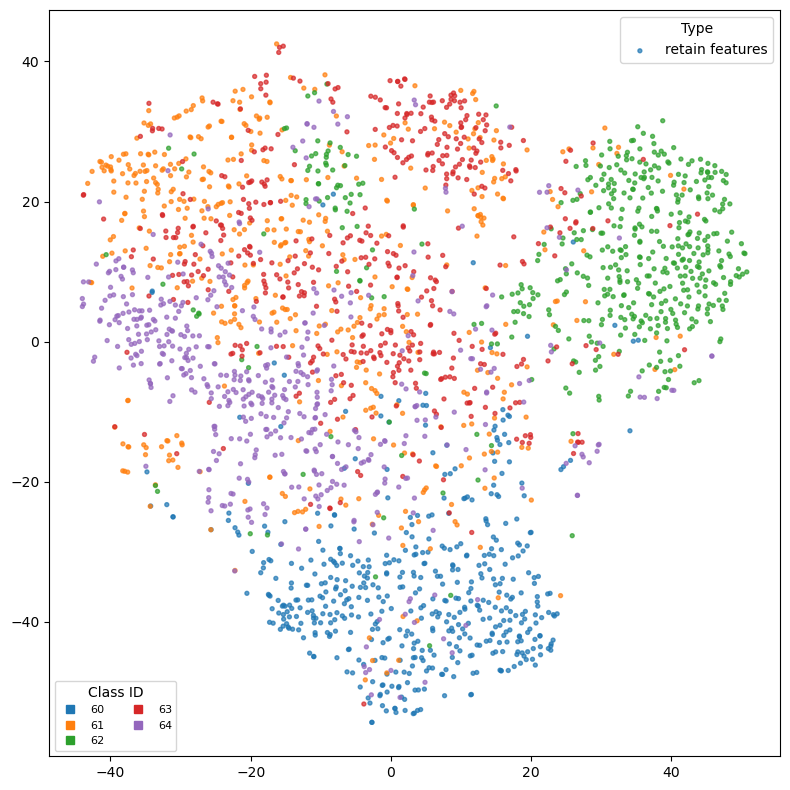

logs/der-mu/baseline0/cifar100/0/10/reproduce_1993_resnet32/plot/7_[60 61 62 63 64].pdf


In [187]:
from matplotlib.lines import Line2D  # まだインポートしてなければ追加

plt.figure(figsize=(8, 8))

# === 忘却クラス集合 ===
forget_set = set(getattr(model, "forget_classes", []))

# === 実画像 feature のうち忘却 / 維持に分割 ===
is_forget_feat = np.isin(labels_vis, list(forget_set))
idx_feat_forget = np.where(is_forget_feat)[0]
idx_feat_retain = np.where(~is_forget_feat)[0]


# === 色を割り当てる対象となる全クラスID ===
all_label_values = [labels_vis]


all_label_values = np.concatenate(all_label_values)
unique_labels = np.unique(all_label_values)

# === クラスごとの色をはっきり決める ===
# クラス数に応じて tab10 / tab20 を使い分け
if len(unique_labels) <= 10:
    cmap = plt.get_cmap("tab10")
else:
    cmap = plt.get_cmap("tab20")

# cls -> color の辞書
cls_color = {cls: cmap(i % cmap.N) for i, cls in enumerate(unique_labels)}

# === 維持クラスの実画像特徴（小さい丸） ===
if len(idx_feat_retain) > 0:
    colors_retain = [cls_color[int(lbl)] for lbl in labels_vis[idx_feat_retain]]
    plt.scatter(
        feat_2d[idx_feat_retain, 0],
        feat_2d[idx_feat_retain, 1],
        c=colors_retain,
        s=8,
        alpha=0.7,
        marker="o",
        label="retain features",
    )

# === 忘却クラスの実画像特徴（小さい ×） ===
if len(idx_feat_forget) > 0:
    colors_forget = [cls_color[int(lbl)] for lbl in labels_vis[idx_feat_forget]]
    plt.scatter(
        feat_2d[idx_feat_forget, 0],
        feat_2d[idx_feat_forget, 1],
        c=colors_forget,
        s=16,
        alpha=0.8,
        marker="x",
        linewidths=0.8,
        label="forget features",
    )



# === legend を2段構成にする ===
handles_type, labels_type = plt.gca().get_legend_handles_labels()
type_legend = plt.legend(
    handles_type,
    labels_type,
    loc="upper right",
    title="Type",
)
plt.gca().add_artist(type_legend)  # この legend を固定

# 2) クラスIDごとの色 legend
class_handles = []
for cls in unique_labels:
    h = Line2D(
        [], [],
        marker="s", linestyle="",
        color=cls_color[cls],
        label=str(cls),
    )
    class_handles.append(h)

plt.legend(
    handles=class_handles,
    loc="lower left",
    title="Class ID",
    ncol=2,          # クラス数に応じて調整
    fontsize=8,
)

# plt.title(f"Feature space with prototypes & DeepInv (phase {PHASE_ID}, mode={TARGET_MODE})")
plt.tight_layout()

# pdf として保存
save_name = f"{PHASE_ID}_{target_classes}.pdf"
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)
save_path = os.path.join(plot_dir, save_name)
plt.savefig(save_path)
plt.show()

print(save_path)